In [ ]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import umap
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
sns.set(context="paper", style="white")

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#**1. Pre-processing**

## **1.1 "metadata.csv" and "embeddings.csv" files are stored at google drive**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# path: "metadata.csv" and "embeddings.csv" files are stored here
path = '/content/drive/My Drive/Colab Notebooks'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **1.2. metadata dataset**

In [ ]:
%%time
df_metadata = pd.read_csv(os.path.join(path, 'metadata.csv'))

CPU times: user 630 ms, sys: 95.3 ms, total: 726 ms
Wall time: 1.07 s


**Explore its data structure**

In [ ]:
print(f'metadata shape = {df_metadata.shape}')
print(df_metadata.head(5).to_string())

metadata shape = (305520, 11)
           site_id        well_id cell_type experiment  plate  well  site  disease_condition       treatment  treatment_conc                                                                     SMILES
0  HRCE-1_1_AA02_1  HRCE-1_1_AA02      HRCE     HRCE-1      1  AA02     1  Active SARS-CoV-2    Flubendazole             0.1  COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=C1 |c:7,11,13,23,t:5,18,20|
1  HRCE-1_1_AA02_2  HRCE-1_1_AA02      HRCE     HRCE-1      1  AA02     2  Active SARS-CoV-2    Flubendazole             0.1  COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=C1 |c:7,11,13,23,t:5,18,20|
2  HRCE-1_1_AA02_3  HRCE-1_1_AA02      HRCE     HRCE-1      1  AA02     3  Active SARS-CoV-2    Flubendazole             0.1  COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)C=C1 |c:7,11,13,23,t:5,18,20|
3  HRCE-1_1_AA02_4  HRCE-1_1_AA02      HRCE     HRCE-1      1  AA02     4  Active SARS-CoV-2    Flubendazole             0.1  COC(=O)NC1=NC2=C(N1)C=C(C=C2)C(=O)C1=CC=C(F)

In [ ]:
print(df_metadata.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305520 entries, 0 to 305519
Data columns (total 11 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   site_id            305520 non-null  object 
 1   well_id            305520 non-null  object 
 2   cell_type          305520 non-null  object 
 3   experiment         305520 non-null  object 
 4   plate              305520 non-null  int64  
 5   well               305520 non-null  object 
 6   site               305520 non-null  int64  
 7   disease_condition  298616 non-null  object 
 8   treatment          263184 non-null  object 
 9   treatment_conc     263184 non-null  float64
 10  SMILES             263184 non-null  object 
dtypes: float64(1), int64(2), object(8)
memory usage: 25.6+ MB
None


**Check the unique values in each column and whether or not NaN value is existed**  
```NaN existed if 'NaN existed' value = 1 else 0```

In [ ]:
df_metadata_unique = pd.merge(df_metadata.nunique(dropna=False).to_frame(name='Including NaN'),
                              df_metadata.nunique(dropna=True).to_frame(name='Excluding NaN'),
                              left_index=True, 
                              right_index=True)
df_metadata_unique['NaN existed'] = df_metadata_unique['Including NaN'] -  df_metadata_unique['Excluding NaN']                    
df_metadata_unique

,Including NaN,Excluding NaN,NaN existed
site_id,305520,305520,0
well_id,76380,76380,0
cell_type,2,2,0
experiment,4,4,0
plate,27,27,0
well,1340,1340,0
site,4,4,0
disease_condition,4,3,1
treatment,1670,1669,1
treatment_conc,15,14,1


**"cell types" column clearly indicates the unbalanced classess of HRCE and VERO**

In [ ]:
df_metadata['cell_type'].value_counts(dropna=False)

HRCE    284080
VERO     21440
Name: cell_type, dtype: int64

**"experiment" column indicates the balanced classess of experimental replicates within cell type**


In [ ]:
df_metadata['experiment'].value_counts(dropna=False)

HRCE-2    144720
HRCE-1    139360
VERO-1     10720
VERO-2     10720
Name: experiment, dtype: int64

**"disease_condition" column shows the unbalance classes (and contains NaN as indicating above)** 

In [ ]:
df_metadata['disease_condition'].value_counts(dropna=True)

Active SARS-CoV-2            280376
Mock                           9120
UV Inactivated SARS-CoV-2      9120
Name: disease_condition, dtype: int64

**"treatment" column has NaN values which is un-treatment conditions and it corresponds with treatment_conc as well**

In [ ]:
df_metadata['treatment'].value_counts(dropna=False)

NaN                     42336
Thymoquinone              864
Quinine                   864
Imiquimod                 864
Cobicistat                864
                        ...  
etafenone                 144
ursodiol                  144
Abacavir hemisulfate      144
budipine                  144
guanaben                  144
Name: treatment, Length: 1670, dtype: int64

**"treatment_conc" column has NaN values which is corresponding to treatment conditions**

In [ ]:
df_metadata['treatment_conc'].value_counts(dropna=False)

0.100      42732
1.000      42708
0.030      42660
0.300      42660
3.000      42636
0.010      42556
NaN        42336
10.000      3396
0.003       3244
30.000       176
100.000      176
0.250         72
2.500         72
0.025         72
0.001         24
Name: treatment_conc, dtype: int64

## **1.2. Get embeddings dataset**

In [ ]:
%%time
df_embeddings = pd.read_csv(os.path.join(path, 'embeddings.csv'))

CPU times: user 59.7 s, sys: 6.97 s, total: 1min 6s
Wall time: 1min 12s


**Explore its data structure**

In [ ]:
print(f'embeddings shape = {df_embeddings.shape}\n')
# print(df_embeddings.head(5).to_string())

embeddings shape = (305520, 1025)



In [ ]:
df_embeddings.head(5)

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,HRCE-1_10_AA02_1,2.355969,-0.058361,-0.169764,-0.316499,-0.891334,0.581174,-0.284587,-0.279198,-0.146575,-0.175336,-2.455430,-0.139774,-0.337087,1.628435,-0.713946,-0.932534,0.004243,0.066700,-0.101360,0.650752,-0.228591,0.161721,0.321429,0.033850,-2.137448,0.324023,0.473495,-1.583087,0.630035,1.167235,1.016468,0.114833,-1.614943,0.331538,-1.773885,0.291819,-1.851311,0.574511,-0.838225,...,1.142032,-0.845352,0.093382,0.408323,0.577964,0.056492,-0.219693,0.079488,-0.913954,-0.192929,-0.552265,-0.729298,0.322046,0.579591,0.270873,-0.388906,0.919923,0.836804,0.682457,0.297119,0.889674,0.322521,-1.069520,-0.178079,-0.726639,1.354043,0.130381,0.653186,-1.811593,0.995635,0.391186,0.786199,-1.739626,-1.317543,-1.208275,-0.507439,-0.317298,0.285018,-0.091285,-1.553895
1,HRCE-1_10_AA02_2,2.325652,-0.202519,-0.296017,-0.481136,-0.641461,0.702847,0.334191,-0.077498,-0.314538,-0.589848,-2.490217,-0.181231,-0.039784,1.365379,-0.750164,-1.118595,-0.030332,0.001164,-0.168584,0.268857,-0.261462,0.295830,0.098757,-0.273157,-2.191125,0.589241,0.675539,-1.377484,0.503110,1.232063,0.877188,0.037731,-2.015882,0.613051,-1.571816,-0.006229,-1.887402,0.774825,-1.143123,...,1.235851,-0.709567,-0.188990,0.115479,0.347220,-0.160982,-0.243853,0.115886,-0.902359,-0.540325,-0.541267,-0.400601,0.199344,0.564925,0.042079,-0.317985,0.976544,0.643442,0.489271,0.397631,1.442512,0.124368,-0.845888,-0.475685,-0.756450,1.562096,0.041372,1.072753,-2.243567,1.064072,0.638674,1.051621,-1.355659,-1.285210,-1.341911,-0.271349,-0.157707,0.081128,-0.447174,-1.614872
2,HRCE-1_10_AA02_3,2.207082,-0.379794,-0.365562,-0.196667,-0.799039,0.735813,0.081227,-0.393452,0.066324,-0.310497,-2.517209,-0.007386,-0.324284,1.354798,-0.159655,-0.946338,-0.221805,-0.368579,0.012367,0.338378,-0.184463,0.021785,0.129724,-0.135265,-2.196755,0.521846,0.520924,-1.353629,0.475637,1.142019,0.362267,-0.007313,-1.398576,0.783560,-1.463769,0.308247,-1.860861,0.292595,-0.947870,...,1.178260,-0.385114,0.031105,0.127435,0.251906,0.191642,-0.033093,0.409381,-1.048480,-0.147343,-0.743204,-0.728965,0.243104,0.644646,0.315567,-0.127823,0.708322,0.528243,0.930237,0.536356,0.689853,0.141840,-1.067782,-0.362878,-0.588146,1.517695,0.240307,0.686097,-1.572938,1.280373,0.552127,0.775428,-1.616731,-0.868382,-1.334486,-0.774456,-0.363250,0.161023,-0.066745,-1.325545
3,HRCE-1_10_AA02_4,2.452741,0.050658,-0.444642,-0.309758,-0.724900,0.658327,-0.128331,-0.164759,0.279105,-0.344210,-2.443276,-0.089115,-0.078181,1.391756,-0.595112,-1.257158,-0.031952,-0.102510,-0.263153,0.385154,-0.346197,-0.134449,0.394239,-0.035160,-2.316346,0.456331,0.536123,-1.185799,0.305819,1.501016,0.592708,0.074070,-1.457676,0.329900,-1.496578,0.250048,-2.081042,0.583651,-1.115648,...,1.371026,-0.934892,-0.214745,0.473699,0.086849,0.056481,-0.072405,0.099594,-0.783984,-0.301317,0.086680,-0.462799,0.623607,1.015139,0.227311,-0.064943,0.997879,0.573458,0.467447,0.445427,0.902873,0.473135,-0.985256,-0.214621,-0.758221,1.651726,0.115064,0.488322,-1.986303,0.505292,0.689145,1.167066,-1.275786,-2.088455,-1.231964,-0.364454,-0.1

In [ ]:
df_embeddings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 305520 entries, 0 to 305519
Columns: 1025 entries, site_id to feature_1023
dtypes: float64(1024), object(1)
memory usage: 2.3+ GB


**Check the unique values in each column and whether or not NaN value existed**  
```NaN existed if 'NaN existed' value = 1 else 0```  
**Note: NaN is not existed in this dataset --> Don't need to run the below code again**

In [ ]:
test_NaN = False
if test_NaN: 
    df_embeddings_unique = pd.merge(df_embeddings.nunique(dropna=False).to_frame(name='Including NaN'),
                                    df_embeddings.nunique(dropna=True).to_frame(name='Excluding NaN'),
                                    left_index=True, 
                                    right_index=True)
    df_embeddings_unique['NaN existed'] = df_embeddings_unique['Including NaN'] -  df_embeddings_unique['Excluding NaN']
    df_NaN_existed = df_embeddings_unique[df_embeddings_unique['NaN existed'] == 1]
    if df_NaN_existed.empty:
        print('There is no NaN in this embeddings dataset')
    else:
        print('NaN in this embeddings dataset - Need to investigate')

#**2. Get a subset of metadata and embeddings just for CNN classification in Part 3**  
**In this case, we get 9120 rows for each disease condition so that they are balanced classess and also suitable size for running in a colab. However, the "active" class is undersampling.**  
In reality, the oversampling method is better.  
(Ref: "A systematic study of the class imbalance problem in convolutional neural networks"  
https://arxiv.org/abs/1710.05381 )

In [ ]:
df_active = df_metadata[df_metadata['disease_condition'] == 'Active SARS-CoV-2']
df_active_new = df_active.sample(n=9120, random_state=42)
df_uv = df_metadata[df_metadata['disease_condition'] == 'UV Inactivated SARS-CoV-2']
df_mock = df_metadata[df_metadata['disease_condition'] == 'Mock']

df_metadata_new = pd.concat([df_active_new, df_uv, df_mock], axis=0)

In [ ]:
df_metadata_new.shape

(27360, 11)

In [ ]:
df_embeddings.head()

,site_id,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,feature_11,feature_12,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22,feature_23,feature_24,feature_25,feature_26,feature_27,feature_28,feature_29,feature_30,feature_31,feature_32,feature_33,feature_34,feature_35,feature_36,feature_37,feature_38,...,feature_984,feature_985,feature_986,feature_987,feature_988,feature_989,feature_990,feature_991,feature_992,feature_993,feature_994,feature_995,feature_996,feature_997,feature_998,feature_999,feature_1000,feature_1001,feature_1002,feature_1003,feature_1004,feature_1005,feature_1006,feature_1007,feature_1008,feature_1009,feature_1010,feature_1011,feature_1012,feature_1013,feature_1014,feature_1015,feature_1016,feature_1017,feature_1018,feature_1019,feature_1020,feature_1021,feature_1022,feature_1023
0,HRCE-1_10_AA02_1,2.355969,-0.058361,-0.169764,-0.316499,-0.891334,0.581174,-0.284587,-0.279198,-0.146575,-0.175336,-2.455430,-0.139774,-0.337087,1.628435,-0.713946,-0.932534,0.004243,0.066700,-0.101360,0.650752,-0.228591,0.161721,0.321429,0.033850,-2.137448,0.324023,0.473495,-1.583087,0.630035,1.167235,1.016468,0.114833,-1.614943,0.331538,-1.773885,0.291819,-1.851311,0.574511,-0.838225,...,1.142032,-0.845352,0.093382,0.408323,0.577964,0.056492,-0.219693,0.079488,-0.913954,-0.192929,-0.552265,-0.729298,0.322046,0.579591,0.270873,-0.388906,0.919923,0.836804,0.682457,0.297119,0.889674,0.322521,-1.069520,-0.178079,-0.726639,1.354043,0.130381,0.653186,-1.811593,0.995635,0.391186,0.786199,-1.739626,-1.317543,-1.208275,-0.507439,-0.317298,0.285018,-0.091285,-1.553895
1,HRCE-1_10_AA02_2,2.325652,-0.202519,-0.296017,-0.481136,-0.641461,0.702847,0.334191,-0.077498,-0.314538,-0.589848,-2.490217,-0.181231,-0.039784,1.365379,-0.750164,-1.118595,-0.030332,0.001164,-0.168584,0.268857,-0.261462,0.295830,0.098757,-0.273157,-2.191125,0.589241,0.675539,-1.377484,0.503110,1.232063,0.877188,0.037731,-2.015882,0.613051,-1.571816,-0.006229,-1.887402,0.774825,-1.143123,...,1.235851,-0.709567,-0.188990,0.115479,0.347220,-0.160982,-0.243853,0.115886,-0.902359,-0.540325,-0.541267,-0.400601,0.199344,0.564925,0.042079,-0.317985,0.976544,0.643442,0.489271,0.397631,1.442512,0.124368,-0.845888,-0.475685,-0.756450,1.562096,0.041372,1.072753,-2.243567,1.064072,0.638674,1.051621,-1.355659,-1.285210,-1.341911,-0.271349,-0.157707,0.081128,-0.447174,-1.614872
2,HRCE-1_10_AA02_3,2.207082,-0.379794,-0.365562,-0.196667,-0.799039,0.735813,0.081227,-0.393452,0.066324,-0.310497,-2.517209,-0.007386,-0.324284,1.354798,-0.159655,-0.946338,-0.221805,-0.368579,0.012367,0.338378,-0.184463,0.021785,0.129724,-0.135265,-2.196755,0.521846,0.520924,-1.353629,0.475637,1.142019,0.362267,-0.007313,-1.398576,0.783560,-1.463769,0.308247,-1.860861,0.292595,-0.947870,...,1.178260,-0.385114,0.031105,0.127435,0.251906,0.191642,-0.033093,0.409381,-1.048480,-0.147343,-0.743204,-0.728965,0.243104,0.644646,0.315567,-0.127823,0.708322,0.528243,0.930237,0.536356,0.689853,0.141840,-1.067782,-0.362878,-0.588146,1.517695,0.240307,0.686097,-1.572938,1.280373,0.552127,0.775428,-1.616731,-0.868382,-1.334486,-0.774456,-0.363250,0.161023,-0.066745,-1.325545
3,HRCE-1_10_AA02_4,2.452741,0.050658,-0.444642,-0.309758,-0.724900,0.658327,-0.128331,-0.164759,0.279105,-0.344210,-2.443276,-0.089115,-0.078181,1.391756,-0.595112,-1.257158,-0.031952,-0.102510,-0.263153,0.385154,-0.346197,-0.134449,0.394239,-0.035160,-2.316346,0.456331,0.536123,-1.185799,0.305819,1.501016,0.592708,0.074070,-1.457676,0.329900,-1.496578,0.250048,-2.081042,0.583651,-1.115648,...,1.371026,-0.934892,-0.214745,0.473699,0.086849,0.056481,-0.072405,0.099594,-0.783984,-0.301317,0.086680,-0.462799,0.623607,1.015139,0.227311,-0.064943,0.997879,0.573458,0.467447,0.445427,0.902873,0.473135,-0.985256,-0.214621,-0.758221,1.651726,0.115064,0.488322,-1.986303,0.505292,0.689145,1.167066,-1.275786,-2.088455,-1.231964,-0.364454,-0.1

In [ ]:
# Save metadata subset
df_metadata_new.to_csv(os.path.join(path, 'meta_subset.csv'), index=False)

In [ ]:
# Get embeddings suset corresponds to metadata via "site_id"
df_embeddings_new =  df_embeddings[df_embeddings['site_id'].isin(df_metadata_new['site_id'])]
df_embeddings_new.shape

(27360, 1025)

In [ ]:
# Save embeddings subset
df_embeddings_new.to_csv(os.path.join(path, 'embedddings_subset.csv'), index=False)

# **3. Dimensionality Reduction using PCA**  
**(Other options: Matrix Factorization, AutoEncoder)**  
**To reduce the dimensionality for UMAP in Part 2 and Random Forest classification in Part 3.**

In [ ]:
# Set site_id as index
df_embeddings.set_index('site_id', inplace=True)


**Standardized features of embeddings**

In [ ]:
# standardize the embedding features onto unit scale (mean=0 and variance=1)
%%time
X = StandardScaler().fit_transform(df_embeddings)

CPU times: user 3.85 s, sys: 274 ms, total: 4.13 s
Wall time: 4.13 s


**PCA with n_components = 50**

In [ ]:
%%time
n_components = 50

# Model 
pca = PCA(n_components=n_components, svd_solver='auto') 

# Model fitting
pca.fit(X)

CPU times: user 53.8 s, sys: 10.7 s, total: 1min 4s
Wall time: 21.1 s


**Check whether or not n_components = 50 is good enough**

In [ ]:
# Cummulative value: 
print('Cummulative Explained Variance:', sum(pca.explained_variance_ratio_))

Cummulative Explained Variance: 0.8733531359344513


Text(0.5, 0, 'Number of Components')

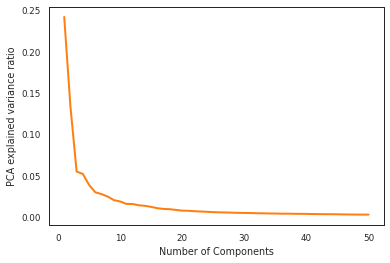

In [ ]:
# Plot a figure of "PCA explained variance ratio"
fig, ax = plt.subplots()
ax.plot(np.arange(1, pca.n_components_ + 1),
        pca.explained_variance_ratio_, linewidth=2, color ='tab:orange')
ax.set_ylabel('PCA explained variance ratio')
ax.set_xlabel('Number of Components')

**As can be seen from explain variance and the figure above,**
**for n_components = 50 and solver = 'auto', the PCA results good enough.**  
**So I will use these latent features.**

**Get latent variables**

In [ ]:
%%time
principal_components = pca.transform(X)

CPU times: user 3.26 s, sys: 124 ms, total: 3.39 s
Wall time: 1.21 s


In [ ]:
principal_components.shape

(305520, 50)

**Transform the latent variables to a scale of range [0, 1] to improve the performance of the classification models.**

In [ ]:
scale_0_1 = MinMaxScaler()
principal_components = scale_0_1.fit_transform(principal_components)

**Save PCA data to a file**

In [ ]:
%%time
np.savez_compressed(os.path.join(path, 'embeddings_pca.npz'), principal_components)

CPU times: user 7.75 s, sys: 128 ms, total: 7.88 s
Wall time: 8.24 s


**End of Part 1**